# Lab 8 Explainability

***
- **FIRST name**: Abimbola
- **LAST name**: Olarinde
- **Student ID**: 1880229

Leave blank if individual:
- **Collaborator names**:
- **Collaborator student IDs**:
***

In today's lab, you will learn:

1.   Using the LIME package for explanations.

For this lab, you'll need the dataset `iris.csv`.

### Instructions

- **Collaboration**: You must submit your own work. The collaboration policy for the labs is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice. You must develop your own solution and submit your own work. All sources of information used including books, websites, students you talked to, must be cited in the submission. Please see the course FAQ document for details on this collaboration policy. We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.
- **Software**: We highly recommend that students use Google Colab for completing labs and assignments. This is the software used by the TAs in the course, and we can guarantee that there will be no issues with incompatible environments or imports.
- **Filling out the Notebook**: You must use this notebook to complete your lab. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided.
- **Important**:  Do not use a different cell, do not delete cells, and do not create a new cell. Creating new cells for your code is not compatible with the auto-grading system we are using and thus your assignment will not get grading properly and you will lose marks for that question. As a reminder you must remove the raise NotImplementedError() statements from each question when answering.
- **Rules for Datasets**: Any datasets used in the lab cannot be imported from cloud storage, e.g google drive, and must be read from a file either on your local computer or uploaded to the google colab notebook. Importing from cloud storage will result in a zero.
- **Submission Formatting**: When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on Canvas the notebook file with your work completed. Name your file with your Student ID number, followed by an underscore and L plus the lab number (ex: 1234567_L8.ipynb). Failure to do so will result in your final score being reduced by 50%! Finally your name must be written at the top of the lab or assignment document.

In [225]:
#run this cell
!pip install lime
import sklearn
import sklearn.ensemble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
np.random.seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

np.random.seed(1)

# 1. Pre-processing the Data

We will use sklearn's dataset module to load the iris dataset

In [226]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
print(iris_df.head(5))
print(iris_df.shape)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
(150, 5)


This dataset contains three iris species: setosa, versicolor, and virginica. It also contains the flower's petal length, petal width, sepal length, and sepal width. Our goal in this lab is to use sklearn's Random Forest Classifer to predict what species of iris we have given its measurements.
To learn more about Random Forests, see [here](https://www.ibm.com/topics/random-forest).

**Question 1.1.** Recall that we denote `X` as our features and `Y` as our target. Separate the dataset into its features and target.

In [227]:
# YOUR CODE HERE
X = pd.DataFrame(iris.data, columns=iris.feature_names)
Y = iris_df['target']


In [228]:
#TEST CELL: do not delete!

# 2. Train

We first split our X and Y datasets in two:
1. Training set: this subset is used to train the model. It usually makes up 80% of the data;
2. Testing set: this subset is used to test the model to see how it performs. It usually makes up 20% of the data.

This is done for the features and the targets separately. It's important that the test data is not used to train the model because it could lead to memorizing the data.

**Question 2.1.** First import sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), then split the data into `X_train`, `X_test`. `Y_train`, and `Y_test` respectively. The parameter `test_size` sets the proportion of data for the testing subset (set to 0.2). The `random_state` parameter controls how much the data is shuffled before being split.

In [229]:
# YOUR CODE HERE
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42


)

Let's first scale the features

In [230]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fit Random Forest model

**Question 2.2.** We use the sklearn function `RandomForestClassifer`to fit our random forest classifier.  Set the parameter `n_estimators` to 500 (visit [this link](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html) if you're having trouble). Assign your answer to `rf_model`.

In [231]:
# YOUR CODE HERE
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, Y_train)



RandomForestClassifier(n_estimators=500, random_state=42)

# 3. Predicting and Assessing

Now that we have our model, we can start making predictions on our iris data.

**Question 3.1.** Use the `.predict` method to make predictions and assign your answer to `Y_pred`. Make sure you use the right feature subset (training vs. testing)!

In [232]:
# YOUR CODE HERE
Y_pred = rf_model.predict(X_test)
print("\nY_pred: ", Y_pred)


Y_pred:  [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


We print the X_test subset and Y_pred to better understand what's going on. X_test contains 30 random flowers and their metrics. Y_pred is an array of 30 predictions where 0 denotes setosa, 1 denotes versicolor, and 2 denotes verginica.

## Explainations

We first need to create the explainer from the lime module.

In [233]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=iris.target_names,
    mode='classification'
)

Now we choose an instance to explain, say the first one in the test set.   

In [234]:
instance = X_test_scaled[0]
print("Predicted class for instance 0:", rf_model.predict([instance]))
print(instance)

Predicted class for instance 0: [0]
[ 0.35451684 -0.58505976  0.55777524  0.02224751]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


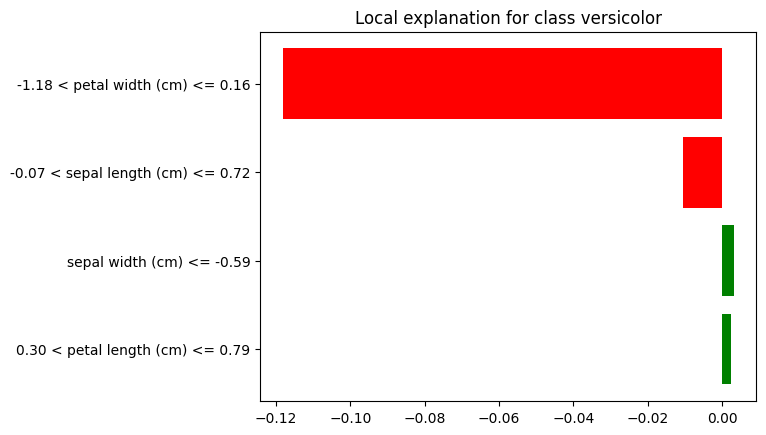

[('-1.18 < petal width (cm) <= 0.16', -0.11817062382156608), ('-0.07 < sepal length (cm) <= 0.72', -0.010561818900076275), ('sepal width (cm) <= -0.59', 0.0031071096602332277), ('0.30 < petal length (cm) <= 0.79', 0.00240713586060737)]


In [235]:
exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=4)

# Visualize explanation
exp.as_pyplot_figure()
plt.show()

# Print feature importance
print(exp.as_list())

**Question 3.2**
Write an explanation for what you see in the visulatization

YOUR ANSWER HERE

The model predicted this iris as versicolor for  "instance = X_test_scaled[2]", and the visualization explains why. The most influential feature was petal width greater than 0.82, which strongly supported the prediction. Other features like sepal length and petal length had small negative influences but weren’t enough to outweigh the strong positive contribution of petal width. This means the model relied mostly on petal width to make its decision for this specific flower.

**Question 3.3** Now get an explanation for another instance and write an explanation of what you see in the visualization.

YOUR ANSWER HERE


The model predicted this iris as versicolor for  "instance = X_test_scaled[0]". However, most of the features shown (like petal width and sepal length) had a negative impact on the prediction. The strongest negative factor was petal width between -1.18 and 0.16, which pushed the prediction away from versicolor. Smaller positive contributions came from sepal width and petal length. This tells us that the model predicted versicolor even though most features didn’t strongly support it, which may suggest some ambiguity in the data for this instance.

# Rubric

| Question | Points|
|----------|----------|
| 1.1.    | 10   |
| 2.1.    | 10   |
| 2.2.    | 10   |
| 3.1.    | 5   |
| 3.2.    | 15   |
| 3.3.    | 15   |
| Total:    | 65   |